$$\require{mhchem}$$
# Transport Problem: Advection + Diffusion, Dispersion + Reaction


$\frac{\partial c}{\partial t}_x = -v\left(\frac{\partial c}{\partial x} \right)$

## Finite-Differences Solution

Advection step:

$\Delta t = v*\Delta x$

Thus:

${c_x}^{t2} = {c_{x-1}}^{t1}$

We need to correct for Numerical dispersion if retardation occurs.

${c_x}^{t2} + {q_x}^{t2} = {c_{x-1}}^{t1} + {q_x}^{t1} + (1-\omega)*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t1}-2 {c_{x}}^{t1}+{c_{x+1}}^{t1}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t1} +(1-2\alpha) {c_{x1}}^{t1} + \alpha {c_{x+1}}^{t1}\right)\right]+  
\omega*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t2}-2 {c_{x}}^{t2}+{c_{x+1}}^{t2}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t2} +(1-2\alpha) {c_{x1}}^{t2} + \alpha {c_{x+1}}^{t2}\right)\right]$

## Model

#### libraries

In [15]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Finite differences scheme:

We are applying our first advection model with a linear retardation scheme.

In [16]:
def iteration_advec(c: np.ndarray, c_in: np.float64):
    result = np.zeros(c.shape)
    
    #Advection:
    result = np.roll(c, 1)
    result[0] = c_in
    c_out = c[-1]
    
    return (result,c_out)

In [17]:
def iteration_crank(c,mixf, omega = 0.5):
    #mixf in vector format
    #Defining mixf terms for implicit and explicit schemes:
    mixfe = mixf*(1-omega)
    mixfi = mixf*omega
    # Calculating the Explicit-part:
    last_term = np.zeros(c.shape)
    # Threre is no fixed boundary, thus:
    last_term[0] = mixfe[1]*c[1] + (1-mixfe[0])*c[0]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(c, (3))
    kernel = np.zeros((3,c.shape[0]-2))
    for i in range(kernel.shape[1]):
        kernel[:,i] = [mixfe[0],1-2*mixfe[i],mixfe[i+1]]
    last_term[1:-1] = np.sum(sliding_window.T*kernel, axis = 0)
    
    #Update the last cell:
    last_term[-1] = mixfe[-1-1]*c[-1-1] + (1-mixfe[-1])*c[-1] 
    
    #Calculating the implicit part:
    
    c = last_term
    A = np.zeros((c.shape[0],c.shape[0]))

    #First row: initial_row:
    A[0,0],A[0,1] = [(1+mixfi[0]),-mixfi[1]]
    #Remaining middle rows:
    for i in range(1,A.shape[0]-1):
        A[i,i-1] = -mixfi[i-1]
        A[i,i] = (1+2*mixfi[i])
        A[i,i+1] = -mixfi[i+1]
    #last row:
    A[c.shape[0]-1,c.shape[0]-2],A[c.shape[0]-1,c.shape[0]-1] = [-mixfi[-2],1+mixfi[-1]]
    
    #RHS of the system of linear equations, with explicit formulation:
    b = c
    
    #Solving the system of equations:
    result = scipy.linalg.solve(A,b)
    return result

#### Sorption Iteration:

In [18]:
def sorb(c, q, Kf, n):
    total = c + q
    def f(c,Kf,n,total):
        if c > 1e-12:
            return c + Kf*np.exp(n*np.log(c)) - total
        else:
            return 0
    for i in range(c.shape[0]):
        c[i] = scipy.optimize.fsolve(f,c[i], (Kf,n,total[i]))
    q = total - c
    return (c,q)

### Retardation calculation>

$R = 1+\frac{\Delta q}{\Delta c} = 1+ \frac{c_{new}-c_{new+react}}{c_{new+react}-c_{old}}$

In [19]:
def calc_R(c_new,c_new_react,c_old):
    R = 1+(c_new-c_new_react)/(c_new_react+c_old)
    R = np.where(R > 1, R,1)
    return R

#### Correction for sorption:

In [20]:
def sorp_corr(v,D, alpha_l, deltax,deltat, R, n_sub):
    alpha_mix = alpha_l-(deltax/2-v*deltat/(2*R))
    mixf = (D*deltat/(deltax**2)+alpha_mix*v*deltat/deltax**2)/n_sub
    return mixf

### Model

In [31]:
def run_model(c_in, v, D, alpha_l, Kf,n, c0, q0, totx, max_time):
    
    # Defining grid for the advection iteration:
    #Delta x criteria:
    #suggest deltax
    maxdeltax = 0.05
    def condition_deltax(maxdeltax,alpha_l,R):
        cond = alpha_l*2*R/(R-1)
        return cond
    ##Correcting the xcells
    x_steps = np.ceil(totx/maxdeltax).astype(np.int32)
    ##Ensuring at least 10 cells
    if x_steps < 10:
        x_steps = 10
    #Delta x:
    deltax = totx/x_steps
    #delta t for the advection:
    deltat = deltax/v
    
    print(f'number of cells: {x_steps}')
    print(f'deltax: {deltax}')
    print(f'deltat: {deltat}')
    
    
    #deltat for the diffusion/dispersion:
    maxdeltat_diff = deltax**2/(3*(D+alpha_l*v))
    n_sub = np.floor(deltat/maxdeltat_diff).astype(np.int32)
    deltat_diff = deltat/n_sub
    
    #Defining time_steps
    n_iter = np.ceil(max_time/deltat).astype(np.int32)
    timesteps = np.arange(deltat,(n_iter +1)*deltat,deltat)
    
    #Defining output:
    cell_history = np.zeros((n_iter,x_steps), dtype = np.float64)
    outflow = np.zeros(n_iter)
    
    #Initial condition arrays:
    c = np.repeat(c0,x_steps)
    q = np.repeat(q0,x_steps)
    
    deltax_violations = 0
    #Running model
    for i in range(n_iter):
        #Advect
        c_old = c.copy()
        c,c_out = iteration_advec(c,c_in)
        c_new = c.copy()
        #Sorb
        c,q = sorb(c, q, Kf, n)
        c_new_react = c.copy()
        
        #Calculate retardation:
        R = calc_R(c_new,c_new_react,c_old)
        
        #Check if delta x is ok:
        if maxdeltax < condition_deltax(maxdeltax,alpha_l,np.max(R)):
            deltax_violations += 1
        
        #Diffuse/Disperse
        #Calculating diffusion/dispersion parameters:
        
        mixf = sorp_corr(v,D, alpha_l, deltax,deltat, R, n_sub)
       
        for j in range(n_sub):
            c = iteration_crank(c, mixf)
        cell_history[i,:] = c
        outflow[i] = c_out
        
    print(f'With the following setup there was deltax criterium violation in {deltax_violations} from {n_iter} iterations')
    
    return (cell_history,outflow, timesteps)
    

#### Running Problem:

Model the linear retardation of y-HCH in a 5 cm long and 5 cm diameter lab column with a sandy aquifer sample.

#### input

In [22]:
organic_carbon_aquifer = 0.05 #%
porosity = 0.3
alpha_l = 7*1e-2 #dispersivity [mm]
injected_volume = 450 #ml
flow_rate = 10*1e-3 #l/hr
De = 1e-9
Kd = 6
c_in = 1 #microg/L

In [23]:
c0 = 0
q0 = 0
v = flow_rate/(np.pi*2.5**2*1e-2)/porosity
pore_volume = (np.pi*2.5**2)*5*1e-3
totx = 0.5
Kf = 1
n = 0.5
max_time = 150

In [32]:
c_out,c_outflow, timesteps = run_model(c_in, v, De, alpha_l, Kf, n, c0, q0, totx, max_time)

number of cells: 10
deltax: 0.05
deltat: 0.2945243112740431
[inf  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         1.79127365 2.1485987  5.3634362  1.         1.
 1.         1.         1.         1.        ]
[1.         1.29307903 1.46337971 1.71359698 2.83843448 1.
 1.         1.         1.         1.        ]
[1.         1.14470916 1.21658636 1.36668659 1.74917167 4.96753801
 1.         1.         1.         1.        ]
[1.         1.08040736 1.11926599 1.21105748 1.43901099 1.80415783
 7.80883266 1.         1.         1.        ]
[ 1.          1.04911352  1.07264163  1.12989949  1.26076116  1.49245015
  1.89594022 15.05962932  1.          1.        ]
[1.         1.03213169 1.04753713 1.08434345 1.16220504 1.30236939
 1.57331617 2.05743594 1.         1.        ]
[1.         1.02215472 1.03281167 1.05736742 1.1056986  1.19225168
 1.35783527 1.67643292 2.40645532 1.        ]
[1.         1.01590913 1.02357899 1.04057643 1.07199191 1.12708306
 1.23049656 1.

C:\Users\vcant\AppData\Local\Temp\ipykernel_2996\4294956756.py:2: RuntimeWarning: divide by zero encountered in true_divide
  R = 1+(c_new-c_new_react)/(c_new_react+c_old)
C:\Users\vcant\AppData\Local\Temp\ipykernel_2996\4294956756.py:2: RuntimeWarning: invalid value encountered in true_divide
  R = 1+(c_new-c_new_react)/(c_new_react+c_old)
C:\Users\vcant\AppData\Local\Temp\ipykernel_2996\1187250094.py:8: RuntimeWarning: invalid value encountered in double_scalars
  cond = alpha_l*2*R/(R-1)
C:\Users\vcant\AppData\Local\Temp\ipykernel_2996\1187250094.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  cond = alpha_l*2*R/(R-1)


[1.         1.00000611 1.00000896 1.00001417 1.00002151 1.00003111
 1.00004304 1.00005689 1.00007137 1.00008408]
[1.         1.00000523 1.00000767 1.00001213 1.00001841 1.00002662
 1.00003682 1.00004866 1.00006104 1.0000719 ]
[1.         1.00000448 1.00000656 1.00001038 1.00001575 1.00002277
 1.0000315  1.00004162 1.0000522  1.00006149]
[1.         1.00000383 1.00000562 1.00000888 1.00001348 1.00001948
 1.00002695 1.0000356  1.00004465 1.00005259]
[1.         1.00000328 1.00000481 1.0000076  1.00001153 1.00001667
 1.00002305 1.00003046 1.00003819 1.00004498]
[1.         1.00000281 1.00000411 1.0000065  1.00000987 1.00001426
 1.00001972 1.00002606 1.00003267 1.00003848]
[1.         1.0000024  1.00000352 1.00000556 1.00000844 1.0000122
 1.00001688 1.00002229 1.00002795 1.00003291]
[1.         1.00000205 1.00000301 1.00000476 1.00000722 1.00001044
 1.00001444 1.00001907 1.00002391 1.00002815]
[1.         1.00000176 1.00000258 1.00000407 1.00000618 1.00000893
 1.00001235 1.00001631 1.00002

In [34]:
cumulated_volume = flow_rate*timesteps

In [35]:
pore_flushes = cumulated_volume/pore_volume
pore_flushes[::30]

array([ 0.03,  0.93,  1.83,  2.73,  3.63,  4.53,  5.43,  6.33,  7.23,
        8.13,  9.03,  9.93, 10.83, 11.73, 12.63, 13.53, 14.43])

#### Plotting and comparing solutions:

Text(0, 0.5, '[y-HCH] [$\\mu g/L$]')

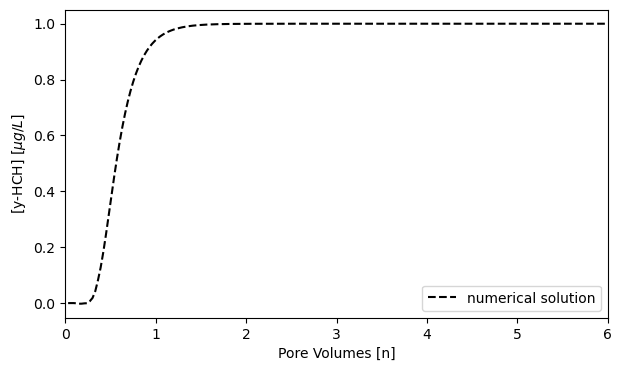

In [36]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(pore_flushes,c_outflow,'--k', label = 'numerical solution')
#ax.plot(pore_flushes[::30],c_out_ana[::30], 'Dr', label = 'analytical solution')
ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('Pore Volumes [n]')
ax.set_ylabel(r'[y-HCH] [$\mu g/L$]')

In [37]:
np.min(c_outflow)

-0.0022694345135664006